In [2]:
import os
import numpy as np
import pandas as pd



import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
def import_datasets(imgpath, dfpath, train_size, valid_size, img_size, batch_size):
    """
    Import the label dataset and create the train, validation, and, test set.

    Parameters:
    imgpath (str): A string containing the path to the folder with images.
    dfpath (str): A string containing the path to the csv with labels.
    train_size (float): The portion depicting the training size.
    valid_size (float): The portion depicting the validation size.
    img_size (tuples): The size of the image in a tuple.
    batch_size (int): The batch size of the data generator.

    Returns:
    train (object): Training batches of images.
    val (object): Validation batches of images.
    test (object): Test batches of images.
    """

    generator = ImageDataGenerator()
    datasets = []

    # Import the csv from path.
    df = pd.read_csv(dfpath)

    # Encode a label of pizzas without labeled toppings.
    df["plain"] = 0
    df["image_name"] = df["image_name"].apply(lambda x: os.path.join(imgpath, x))
    df.loc[df.iloc[:, 1:-1].max(axis=1) == 0, "plain"] = 1

    # Split the data in training and validation.
    train_df, dummy_df = train_test_split(
        df, train_size=train_size, shuffle=True, random_state=7
    )
    valid_df, test_df = train_test_split(
        dummy_df, train_size=valid_size, shuffle=True, random_state=7
    )

    # Use the ImageDataGenerator from Keras to create batch data.
    for dataset in [train_df, valid_df, test_df]:
        data_generator = generator.flow_from_dataframe(
            dataset,
            x_col="image_name",
            y_col=df.columns[1:],
            target_size=img_size,
            batch_size=batch_size,
            shuffle=True,
            seed=7,
            class_mode="raw",
        )
        datasets.append(data_generator)
    train, val, test = datasets

    return train, val, test, df


train, val, test, df = import_datasets(
    imgpath="data\pizza_data\images",
    dfpath="data\pizza_data\labels.csv",
    train_size=0.8,
    valid_size=0.5,
    img_size=(1080, 1080),
    batch_size=30,
)

df

Found 7370 validated image filenames.
Found 921 validated image filenames.
Found 922 validated image filenames.


,image_name,pepperoni,bacon,mushrooms,onions,peppers,black_olives,tomatoes,spinach,fresh_basil,arugula,broccoli,corn,pineapple,plain
0,data\pizza_data\images\00001.jpg,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,data\pizza_data\images\00002.jpg,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,data\pizza_data\images\00003.jpg,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,data\pizza_data\images\00004.jpg,0,0,0,1,1,0,0,0,0,0,0,0,0,0
4,data\pizza_data\images\00005.jpg,1,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9208,data\pizza_data\images\09209.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9209,data\pizza_data\images\09210.jpg,0,0,0,0,0,1,0,0,0,0,0,0,0,0
9210,data\pizza_data\images\09211.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9211,data\pizza_data\images\09212.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,1


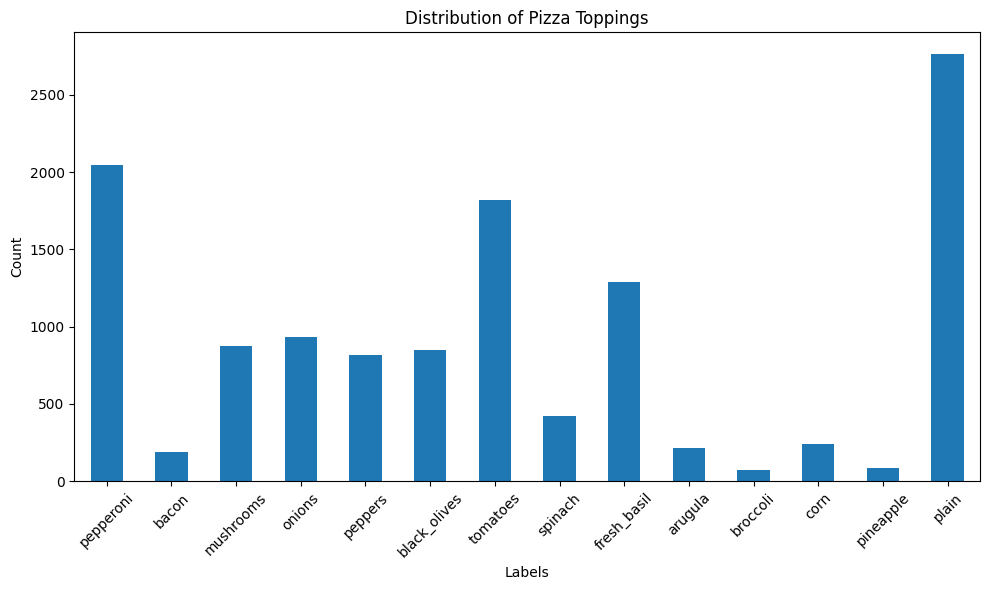

In [72]:
# Calculate the count of occurrences of each label
label_counts = df.drop(columns="image_name").sum()

# Plotting the distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind="bar")
plt.title("Distribution of Pizza Toppings")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

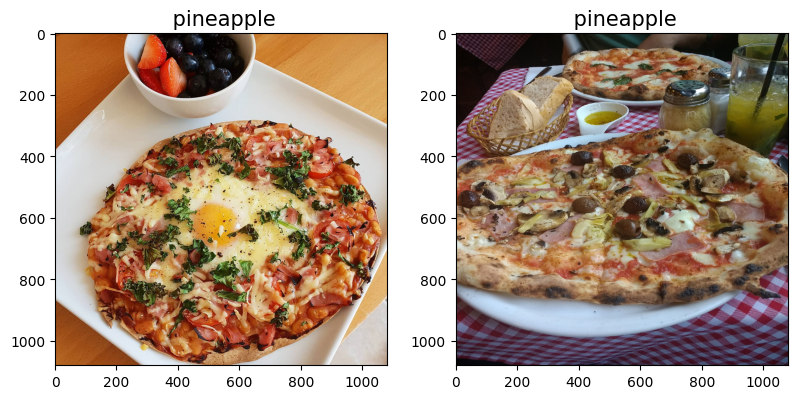

In [9]:
def display_samples(img, classes, num_images):
    images, labels = next(img)
    plt.figure(figsize=(25, 25))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        label = labels[i]
        title = ""
        for j in range(len(label)):
            value = label[j]
            if value == 1:
                title = title + " " + classes[j]
        plt.imshow(image)
        plt.title(title, fontsize=15)
    plt.show()


display_samples(train, df.columns, 2)

In [15]:
train

In [21]:
images, labels = next(train)
images[0].shape

(1080, 1080, 3)